## ETL 
Création des données supplémentaire

In [ ]:
!cat ./data/spike_data_708.fasta | grep ">" | sed "s/>//" > ./data/spike_header_cl.txt 

Chargement des modules nécessaires

In [26]:
from ete3 import Tree, PhyloTree, TreeStyle, NodeStyle, TextFace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Importation des données supplémentaires

In [27]:
prot_names = []
prot_dates = []
prot_origin = []

with open("./data/spike_header_cl.txt", "r") as filein:
    for ligne in filein:
        l_spl = ligne.split("|")
        prot_names.append(l_spl[0].split()[0])
        prot_origin.append(l_spl[1].split('"')[1])
        prot_dates.append(l_spl[2])

# organiser as dataframe
spike_df = pd.DataFrame(data = {"name" : prot_names,
                                "origin" : prot_origin,
                                "date" : prot_dates})
spike_df["date"] = pd.to_datetime(spike_df["date"])
spike_df.index = spike_df["name"]

Importation des données de l'arbre

In [28]:
tree_root = PhyloTree(newick = "./data/nj_tree.nwk", format = 1)#, alignment = "./data/clustalo_alg.fasta", alg_format = "fasta")

## Exploration du dataset

In [29]:
leaf_clo, dist_to_leaf = tree_root.get_closest_leaf()
print(f"La distance à la plus proche feuille {leaf_clo.name} est : {dist_to_leaf}\n"
     f"Son origine est {spike_df.loc[leaf_clo.name]['origin']}, sa date de séquençage est le {spike_df.loc[leaf_clo.name]['date']}")
leaf_far, dist_to_leaf_far = tree_root.get_farthest_leaf()
print(f"La distance à la plus lointaine feuille {leaf_far.name} est : {dist_to_leaf_far}\n"
     f"Son origine est {spike_df.loc[leaf_far.name]['origin']}, sa date de séquençage est le {spike_df.loc[leaf_far.name]['date']}")

La distance à la plus proche feuille QZW38759.1 est : -7.004623660614162e-17
Son origine est USA, sa date de séquençage est le 2021-08-25 00:00:00
La distance à la plus lointaine feuille QRW61256.1 est : 0.7725499999999998
Son origine est USA, sa date de séquençage est le 2020-12-24 00:00:00


In [30]:
print(f"Notre dataset possède {spike_df.shape[0]} séquences, que nous avons organisées en arbre.\n"
      f"Les pays d'origine de ces séquences sont {', '.join(set(spike_df['origin']))}, mais la représentation n'est pas équilibrée "
     "entre ces différents pays")

Notre dataset possède 708 séquences, que nous avons organisées en arbre.
Les pays d'origine de ces séquences sont France, Lebanon, India, Chile, Georgia, USA, United Kingdom, China, Saudi Arabia, Bangladesh, Australia, Russia, Ghana, Italy, Germany, Spain, Thailand, Egypt, mais la représentation n'est pas équilibrée entre ces différents pays


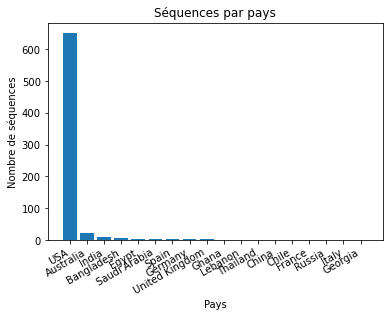

In [31]:
count_by_or = spike_df["origin"].value_counts()
plt.bar(count_by_or.index, count_by_or)
plt.title("Séquences par pays")
plt.xlabel("Pays")
plt.ylabel("Nombre de séquences")
plt.xticks(rotation=30, ha='right')
plt.savefig("test_bar.png")

## Cas d'étude : Australie
Etant donné le grand nombre de séquences dans nos données, afin de démontrer les capacités d'exploration et d'analyse des arbres, nous allons étudier un sous ensemble de nos données : les séquences provenant d'Australie

In [32]:
spike_df["origin"].value_counts()

USA               651
Australia          21
India               9
Bangladesh          5
Egypt               4
Saudi Arabia        3
Spain               2
Germany             2
United Kingdom      2
Ghana               1
Lebanon             1
Thailand            1
China               1
Chile               1
France              1
Russia              1
Italy               1
Georgia             1
Name: origin, dtype: int64

In [33]:
list_austr = list(spike_df.index[spike_df["origin"] == "Australia"])

In [34]:
aus_t = tree_root
aus_t.prune(list_austr)

In [35]:
a = aus_t.render("austr_tree.png", dpi = 600)

![Australian tree](austr_tree.png)

On peut également afficher un titre, et représenter l'arbre de façon circulaire si l'envie nous prend : 

In [36]:
aus_ts = TreeStyle()
aus_ts.show_leaf_name = False
aus_ts.title.add_face(TextFace("Arbre Australien", fsize=20), column=0)
aus_ts.mode = "c"
aus_ts.arc_start = -180
aus_ts.arc_span = 180
a = aus_t.render("aus_tree_circ.png", dpi = 200, tree_style = aus_ts)

![Circular tree](aus_tree_circ.png)

Dans les deux représentations, nous pouvons observe que la majorité des séquences sont très proches, même si 8 d'entre elles sont nettement plus loin.
Une des choses les plus intéressante serait de pouvoir distinguer nos feuilles par date. Tout d'abord, il est intéressant d'étudier la distribution des dates dans nos 21 séquences.

In [37]:
spike_df[spike_df["origin"] == "Australia"]["date"].describe(datetime_is_numeric = True)

count                               21
mean     2020-05-24 02:17:08.571428608
min                2020-03-19 00:00:00
25%                2020-03-31 00:00:00
50%                2020-06-12 00:00:00
75%                2020-07-05 00:00:00
max                2020-08-20 00:00:00
Name: date, dtype: object

Nous pouvons observer que les protéines spike du virus ont tous été séquencés entre mars et août 2020, et que 5 d'entre elles l'ont été en mars 2020. Nous pouvons essayer de représenter cette distribution en représentant la distribution cumulée des dates : 

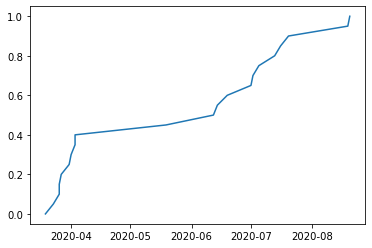

In [38]:
x = np.sort(spike_df[spike_df["origin"] == "Australia"]["date"])
y = np.linspace(0, 1, len(x))
plt.plot(x, y)
plt.savefig("cdf.png")

Mais il serait plus intéressant d'afficher directement sur l'arbre ces différentes dates : 

In [39]:
date_med = spike_df[spike_df["origin"] == "Australia"]["date"].quantile(0.5, interpolation = "midpoint")
# Une manière d'itérer sur les feuilles :
for leaf in aus_t.iter_leaves():
    # Ajouter la date à chaque feuille
    leaf.add_face(TextFace(str(spike_df.loc[leaf.name, "date"]).split()[0]), column = 0)
    # colorer par date
    leaf_style = NodeStyle()
    if spike_df.loc[leaf.name, "date"] <= date_med:
        leaf_style["bgcolor"] = "#ffbfbf"
    else:
        leaf_style["bgcolor"] = "#bfbfff"
    leaf.set_style(leaf_style)

In [40]:
a = aus_t.render("aus_tree_date.png", dpi = 600)
del a 

![Arbre](aus_tree_date.png)

Les regroupements visibles dans l'arbre semblent en partie correspondre à la date de séquençage. En effet, les deux groupes qui se dessinent contiennent tous deux des séquences de mars 2020. Il semble y en avoir un peu plus dans le groupe le plus détaché, malgré tout. En outre, le groupe le plus détaché possède une seule séquence de la seconde moitié de notre échantillon.